<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Anomaly_Sound_Detection_MobileNet_stratified_one_hold_multigpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[機械稼働音の異常検知](https://signate.jp/competitions/358)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
checkpoint_path = "./cp.ckpt"

In [3]:
%pip install tensorflow==2.15

## Unpack Zip file in which Melspectram images are.

In [4]:
import os
import shutil
if os.path.isdir('./train_img'):
  shutil.rmtree('./train_img')
if os.path.isdir('./test_img'):
  shutil.rmtree('./test_img')

In [5]:
!cp "/content/drive/MyDrive/Detect_Anormaly_Machines_by_Sound/01_input.zip" .

In [6]:
import shutil
shutil.unpack_archive('/content/01_input.zip', '.')

## Import modules

In [7]:
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, datasets, layers, applications, optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Reading CSV

In [8]:
df = pd.read_csv("./train.csv")
df["status"] = df["status"].astype(str)
display(df)

,image,status
0,valid_normal_018.png,0
1,valid_normal_024.png,0
2,valid_normal_030.png,0
3,train_normal_210.png,0
4,train_normal_204.png,0
...,...,...
495,valid_anomaly_030.png,1
496,valid_anomaly_026.png,1
497,valid_anomaly_032.png,1
498,valid_anomaly_033.png,1


## CNN Model

In [9]:
IMG_WIDTH = 320
IMG_HEIGHT = 240
IMG_DEPTH = 3

BATCH_SIZE = 32
train_dir = './train_img/'

In [10]:
lr:float = 0.001 # Default:0.001

#strategy = tf.distribute.MirroredStrategy()
#with strategy.scope():

base_model = applications.mobilenet.MobileNet(weights='imagenet',
                                        include_top=False,
                                        input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH)
                                      )

model = models.Sequential([
  base_model,
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

adam_low_rate = optimizers.Adam(learning_rate=lr)

# モデルを構築
model.compile(optimizer = adam_low_rate,
              loss = "binary_crossentropy",
              metrics = ['accuracy']
            )

## Generating Image

In [11]:
'''
from sklearn.model_selection import StratifiedKFold

N_SPLIT = 5

# String the average of all predictions
main_pred = []
data_kfold = pd.DataFrame()

# k-fold
skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
'''

'\nfrom sklearn.model_selection import StratifiedKFold\n\nN_SPLIT = 5\n\n# String the average of all predictions\nmain_pred = []\ndata_kfold = pd.DataFrame()\n\n# k-fold\nskf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=42)\n'

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
                              rescale=1./255, # 255で割ることで正規化
                              zoom_range=0.2, # ランダムにズーム
                              horizontal_flip = True, # 水平反転
                              height_shift_range=0.1,
                            )
valid_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
TEST_DIR = "./test_img/"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(TEST_DIR, target_size=(IMG_WIDTH,IMG_HEIGHT), class_mode=None, shuffle=False)

Found 200 images belonging to 1 classes.


Found 400 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Epoch 1/50
13/13 [==============================] - 212s 14s/step - loss: 8.4361 - accuracy: 0.7700 - val_loss: 10.3962 - val_accuracy: 0.9000
Epoch 2/50
13/13 [==============================] - 179s 13s/step - loss: 1.3384 - accuracy: 0.8600 - val_loss: 9.7153 - val_accuracy: 0.9000
Epoch 3/50
13/13 [==============================] - 170s 13s/step - loss: 0.2722 - accuracy: 0.9050 - val_loss: 8.3394 - val_accuracy: 0.9000
Epoch 4/50
13/13 [==============================] - 178s 13s/step - loss: 0.1317 - accuracy: 0.9600 - val_loss: 5.0920 - val_accuracy: 0.9000
Epoch 5/50
13/13 [==============================] - 176s 13s/step - loss: 0.0631 - accuracy: 0.9900 - val_loss: 5.0622 - val_accuracy: 0.9000
Epoch 6/50
13/13 [==============================] - 176s 13s/step - loss: 0.0496 - accuracy: 0.9900 - val_loss: 3.0675 - val_accuracy: 0.9000
Epoch 7/50
13/13 [=========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


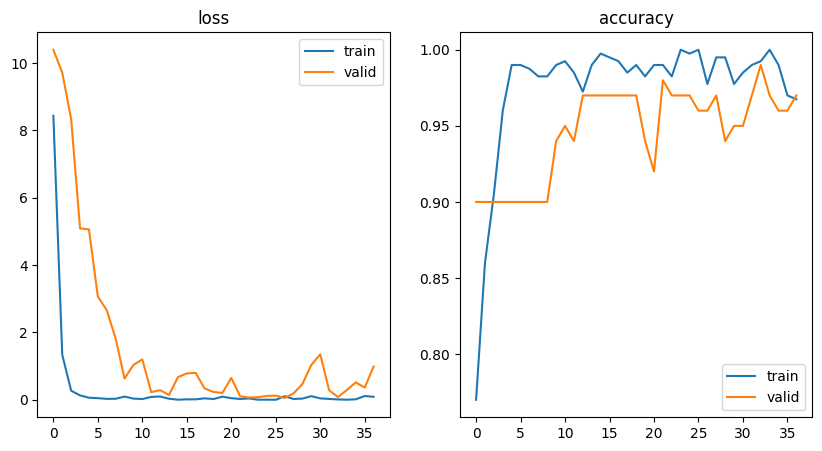

In [18]:
epochs:int = 50 # Defalut:50

from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df['status'], random_state=42)

train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
                                                    x_col = 'image',
                                                    y_col = 'status',
                                                    directory = train_dir,
                                                    target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'binary',
                                                    shuffle = True,
                                                  )

valid_generator = valid_datagen.flow_from_dataframe(dataframe = valid_df,
                                                    x_col = 'image',
                                                    y_col = 'status',
                                                    directory = train_dir,
                                                    target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'binary',
                                                    shuffle = True,
                                                  )

history = model.fit(train_generator,
                    validation_data = valid_generator,
                    verbose=True,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)],
                    epochs = epochs,
)

# 評価する。
test_loss, test_acc = model.evaluate(valid_generator)

model.save('model.h5')

plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意
metrics = ['loss', 'accuracy']  # 使用する評価関数を指定

for i in range(len(metrics)):
  metric = metrics[i]

  plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分ける
  plt.title(metric)

  plt_train = history.history[metric]
  plt_valid  = history.history['val_' + metric]

  plt.plot(plt_train, label='train')
  plt.plot(plt_valid, label='valid')
  plt.legend()

plt.savefig("./metrics.png")

In [ ]:
'''
import gc

epochs:int = 50 # Defalut:50

# Variable for keeping count of split we are executing
j = 0
data_kfold = pd.DataFrame()

valid_targets = np.array([])
actual_targets = np.array([])

# Stratified K-fold Train and test for each split
for train_idx, val_idx in list(skf.split(df['image'], df['status'])):
  train_df = df.iloc[train_idx]
  valid_df = df.iloc[val_idx]

  j += 1
  print("Split: ", j)

  train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
                                                      x_col = 'image',
                                                      y_col = 'status',
                                                      directory = train_dir,
                                                      target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                      batch_size = BATCH_SIZE,
                                                      class_mode = 'binary',
                                                      shuffle = True,
                                                    )

  valid_generator = valid_datagen.flow_from_dataframe(dataframe = valid_df,
                                                      x_col = 'image',
                                                      y_col = 'status',
                                                      directory = train_dir,
                                                      target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                      batch_size = BATCH_SIZE,
                                                      class_mode = 'binary',
                                                      shuffle = True,
                                                    )

  history = model.fit(train_generator,
                      validation_data = valid_generator,
                      verbose=True,
                      callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)],
                      epochs = epochs,
  )

  # 評価する。
  test_loss, test_acc = model.evaluate(valid_generator)

  model.save('model.h5')

  plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意
  metrics = ['loss', 'accuracy']  # 使用する評価関数を指定

  for i in range(len(metrics)):
    metric = metrics[i]

    plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分ける
    plt.title(metric)

    plt_train = history.history[metric]
    plt_valid  = history.history['val_' + metric]

    plt.plot(plt_train, label='train')
    plt.plot(plt_valid, label='valid')
    plt.legend()

  plt.savefig("./metrics.png")

  gc.collect()
'''

In [19]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Valid = model.predict(valid_generator, valid_generator.samples)
valid = np.argmax(Valid, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, valid))
print('Classification Report')
print(classification_report(valid_generator.classes, valid, target_names=None))

4/4 [==============================] - 13s 2s/step
Confusion Matrix
[[90  0]
 [10  0]]
Classification Report
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        90
           1       0.00      0.00      0.00        10

    accuracy                           0.90       100
   macro avg       0.45      0.50      0.47       100
weighted avg       0.81      0.90      0.85       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## To Output Submitting CSV

In [20]:
ans = pd.read_csv("/content/drive/MyDrive/Detect_Anormaly_Machines_by_Sound/sample_submit.csv",  header=None)

In [ ]:
'''
dummy_datagen = ImageDataGenerator(rescale=1./255)
dummy_generator = dummy_datagen.flow_from_dataframe(dataframe=df,
                                        directory=train_dir,
                                        x_col="image",
                                        y_col="status",
                                        class_mode='binary',
                                        target_size=(IMG_WIDTH,IMG_HEIGHT),
                                        batch_size=1,
                                        shuffle=False)

# Taking The Label with Maximum Occurences
labels=(dummy_generator.class_indices)
labels2=dict((v,k) for k,v in labels.items())

import collections
for i in range(len(data_kfold)):
  co = collections.Counter(data_kfold.loc[i])
  co = sorted(co.items(),key=lambda x: x[1],reverse=True)
  ans['status'].loc[i] = labels2[co[0][0]]
'''

In [21]:
pred = model.predict(test_generator)
pred = np.where(pred < 0.5, 0, 1)

7/7 [==============================] - 25s 3s/step


In [22]:
ans[1] = pred
ans.to_csv(path_or_buf = "/content/drive/MyDrive/Detect_Anormaly_Machines_by_Sound/submission_.csv", index=False, header=None)

In [23]:
ans

,0,1
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0
...,...,...
195,195,0
196,196,0
197,197,0
198,198,1
